In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
import pandas as pd
import time
from collections import OrderedDict, namedtuple
from itertools import product
from torch.optim import Adam
#from siamese_network import SiameseNetwork  # Import your Siamese model
#from siamese_dataset import SiameseDataset  # Import dataset class for pairs
import random
import matplotlib.pyplot as plt

In [35]:
# RunManager & RunBuilder
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_start_time = None
        self.run_params = None
        self.run_count = 0
        self.run_start_time = None

    def begin_run(self, run):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1
        self.epoch_count = 0

    def end_run(self):
        self.epoch_count = 0

    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_loss = 0
        self.epoch_count += 1

    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        loss = self.epoch_loss / len(train_loader)
        print(f"Epoch {self.epoch_count}, Loss: {loss:.4f}")

    def track_loss(self, loss, batch):
        self.epoch_loss += loss.item() * batch[0].size(0)

In [36]:
# Define Siamese Dataset for Fashion MNIST
class SiameseFashionMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        should_get_same_class = np.random.randint(0, 2)
        if should_get_same_class:
            while True:
                idx = np.random.randint(0, len(self.dataset))
                img2, label2 = self.dataset[idx]
                if label1 == label2:
                    break
        else:
            while True:
                idx = np.random.randint(0, len(self.dataset))
                img2, label2 = self.dataset[idx]
                if label1 != label2:
                    break
        label = torch.tensor([int(label1 == label2)], dtype=torch.float32)
        if self.transform and not isinstance(img1, torch.Tensor):
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, label

    def __len__(self):
        return len(self.dataset)


In [37]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [38]:
# Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


In [39]:
# Load Data
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

siamese_train_dataset = SiameseFashionMNIST(train_dataset, transform=transform)
siamese_test_dataset = SiameseFashionMNIST(test_dataset, transform=transform)

train_loader = DataLoader(siamese_train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(siamese_test_dataset, shuffle=True, batch_size=1)

In [40]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [41]:
# Define Hyperparameter Grid
params = OrderedDict(
    lr=[0.006],  # Learning rates to test
    batch_size=[10000],  # Different batch sizes
    number_epochs=[1, 2],  # Number of epochs
    optimizer=[torch.optim.AdamW]  # Optimizers to test
)

# Initialize RunManager
m = RunManager()
b = RunBuilder.get_runs(params)

# Device Selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

for run in b:
    print(run)

Run(lr=0.006, batch_size=10000, number_epochs=1, optimizer=<class 'torch.optim.adamw.AdamW'>)
Run(lr=0.006, batch_size=10000, number_epochs=2, optimizer=<class 'torch.optim.adamw.AdamW'>)


In [23]:
# Load FashionMNIST dataset and create pairs
train_set = SiameseFashionMNIST(train_dataset, transform=transform)  # Modify your dataset to return pairs
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = SiameseNetwork().to(device)

# Contrastive Loss Function
def contrastive_loss(out1, out2, label, margin=1.0):
    distance = F.pairwise_distance(out1, out2)
    loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                      label * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
    return loss

# Compute Accuracy (Pairs classified correctly)
def get_num_correct(out1, out2, labels, threshold=0.5):
    distances = F.pairwise_distance(out1, out2)
    preds = (distances < threshold).float()  # Predict same class if distance is small
    return torch.eq(preds, labels).sum().item()

max_acc = []
loss_vals = []
torch.cuda.empty_cache()

for run in b:  # Iterate over different hyperparameter combinations
    network = SiameseNetwork().to(device)
    optimizer = run.optimizer(network.parameters(), lr=run.lr)

    best_acc = 0
    best_loss = float('inf')

    for epoch in range(run.number_epochs):
        correct = 0
        total_loss = 0
        for img1, img2, label in train_loader:  # Load pairs of images
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            out1, out2 = network(img1, img2)
            loss = contrastive_loss(out1, out2, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += get_num_correct(out1, out2, label)

        acc = correct / len(train_loader.dataset)
        best_acc = max(best_acc, acc)
        best_loss = min(best_loss, total_loss)

    print(run, ", Accuracy =", best_acc, ", Loss =", best_loss)
    max_acc.append(best_acc)
    loss_vals.append(best_loss)

# Save results
np.savetxt('siamese_accuracy.csv', np.array(max_acc), delimiter=',')
np.savetxt('siamese_loss.csv', np.array(loss_vals), delimiter=',')

print("Best Accuracy at row:", np.argmax(max_acc) + 1, "Accuracy =", np.max(max_acc))
print("Best Loss at row:", np.argmin(loss_vals) + 1, "Loss =", np.min(loss_vals))

Run(lr=0.006, batch_size=10000, number_epochs=1, optimizer=<class 'torch.optim.adamw.AdamW'>) , Accuracy = 50.08416666666667 , Loss = 187.7790008187294
Run(lr=0.006, batch_size=10000, number_epochs=2, optimizer=<class 'torch.optim.adamw.AdamW'>) , Accuracy = 50.0693 , Loss = 182.1652760207653
Best Accuracy at row: 1 Accuracy = 50.08416666666667
Best Loss at row: 2 Loss = 182.1652760207653


In [ ]:
#alternate param optimisation
# Iterate through hyperparameter combinations
#for run in b:
#
 #   # Create DataLoader with dynamic batch size
  #  train_loader = DataLoader(SiameseFashionMNIST(train_dataset, transform=transform),
   #                           shuffle=True, batch_size=run.batch_size)
#
 #   # Initialize model, criterion, and optimizer dynamically
  #  model = SiameseNetwork().to(device)
   # criterion = ContrastiveLoss()
    #optimizer = run.optimizer(model.parameters(), lr=run.lr)
#
 #   # Start run
  #  m.begin_run(run)
#
 #   for epoch in range(run.number_epochs):
  #      m.begin_epoch()
   #     model.train()
#
 #       for batch_idx, (img1, img2, label) in enumerate(train_loader):
  #          img1, img2, label = img1.to(device), img2.to(device), label.to(device)
#
 #           optimizer.zero_grad()
  #          output1, output2 = model(img1, img2)
   #         loss = criterion(output1, output2, label)
    #        loss.backward()
     #       optimizer.step()
#
 #           m.track_loss(loss, (img1, img2))
#
 #           if batch_idx % 100 == 0:
  #              print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
#
 #       m.end_epoch()
#
 #   m.end_run()
  #  print("Training Complete for this parameter set!\n")

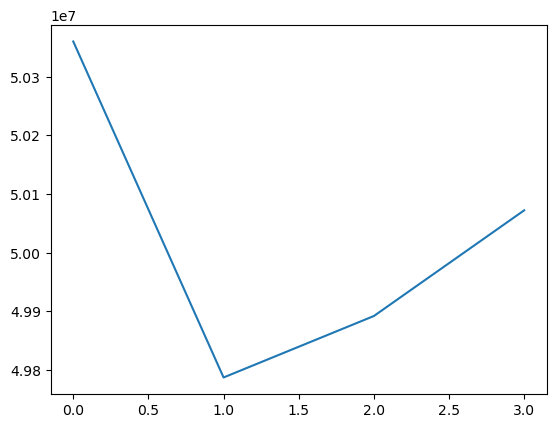

50360000.0


C:\Users\user\AppData\Local\Temp\ipykernel_15884\1551222301.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  help_me.load_state_dict(torch.load('network.pth'))


SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [43]:
#saving the CNN network 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10000, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = SiameseNetwork().to(device)
optimizer = optim.AdamW(network.parameters(), lr=0.006)

batch = next(iter(train_loader))
img1, img2, labels = batch
img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

number_run = 4
holdall = np.zeros(number_run)

def get_num_correct(out1, out2, labels, threshold=0.5):
    distances = F.pairwise_distance(out1, out2)
    preds = (distances < threshold).float()  # Predict "same class" if distance is small
    return torch.eq(preds, labels).sum().item()  # Count correct predictions

for I in range(number_run):
    out1, out2 = network(img1, img2)
    loss = ContrastiveLoss()(out1, out2, labels)
    holdall[I] = get_num_correct(out1, out2, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

plt.plot(holdall)
plt.show()
max_value = holdall.max()
print(max_value)

torch.save(network.state_dict(), 'network.pth')

help_me = SiameseNetwork().to(device)
help_me.load_state_dict(torch.load('network.pth'))
help_me.eval()